# Transfer Learning

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [3]:
train_dataset = torchvision.datasets.CIFAR100(root='./data',
                                              train=True,
                                              download=True,
                                              transform=data_transforms['train'])

test_dataset = torchvision.datasets.CIFAR100(root='./data',
                                             train=False,
                                             download=True,
                                             transform = data_transforms['val'])

val_dataset = torchvision.datasets.CIFAR100(root='./data',
                                            train=False,
                                            download=True,
                                            transform=data_transforms['val'])

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
image_datasets = { 'train': train_dataset,
                  'val': val_dataset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=8,
                                              pin_memory = True,
                                              shuffle=True,
                                              num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [5]:
inputs, classes = next(iter(dataloaders['train']))
inputs.shape

torch.Size([8, 3, 224, 224])

In [6]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1,2,0))
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [7]:
# Getting a batch of training data
inputs, classes = next(iter(dataloaders['train']))

In [8]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

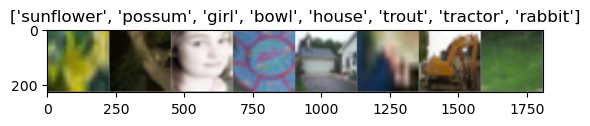

In [9]:
imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model,
                criterion,
                optimizer,
                scheduler,
                num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-'*10)
        
        '''
        Each epoch has a training and validation phase
        '''
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                #backward + optimize only if in training phase
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            # if phase == 'train':
            #     scheduler.step()
            
            epoch_loss = running_loss /dataset_sizes[phase]
            epoch_acc = running_corrects.double() /dataset_sizes[phase]
            if phase == 'val':
                scheduler.step(epoch_acc)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.IMAGENET1K_V1')

for params in model.parameters():
            params.requires_grad = True
        
model.classifier[1] = nn.Linear(in_features=1280, out_features=100)
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.0001)

In [15]:
scheduler = lr_scheduler.StepLR(optimizer=optimizer,
                                        step_size=7,
                                        gamma=0.1)

# scheduler = lr_scheduler.OneCycleLR(optimizer = optimizer,
#                                      max_lr=0.01,
#                                      epochs=25, 
#                                      steps_per_epoch=len(train_loader))

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='max',
                                           factor=0.5,
                                           patience=5,
                                           min_lr=1e-6,
                                           verbose=True
                                           )

Learning Rate scheduling should be applied after optmizer's update
E.g: We should write the code in this way
```python
for epoch in range(100):
    train(...) #optimizer.step()
    validate(...)
    scheduler.step()
```

In [16]:
%%time 

model = train_model(model,criterion, optimizer, scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.7445 Acc: 0.3346
val Loss: 1.1328 Acc: 0.6682

Epoch 1/24
----------
train Loss: 1.9193 Acc: 0.5022
val Loss: 0.9216 Acc: 0.7370

Epoch 2/24
----------
train Loss: 1.7180 Acc: 0.5486
val Loss: 0.8847 Acc: 0.7535

Epoch 3/24
----------
train Loss: 1.5916 Acc: 0.5809
val Loss: 0.8406 Acc: 0.7760

Epoch 4/24
----------
train Loss: 1.5053 Acc: 0.6014
val Loss: 0.8188 Acc: 0.7832

Epoch 5/24
----------
train Loss: 1.4229 Acc: 0.6223
val Loss: 0.8197 Acc: 0.7840

Epoch 6/24
----------
train Loss: 1.3582 Acc: 0.6352
val Loss: 0.7889 Acc: 0.7940

Epoch 7/24
----------
train Loss: 1.3154 Acc: 0.6480
val Loss: 0.7656 Acc: 0.8016

Epoch 8/24
----------
train Loss: 1.2781 Acc: 0.6571
val Loss: 0.7676 Acc: 0.8004

Epoch 9/24
----------
train Loss: 1.2421 Acc: 0.6653
val Loss: 0.7851 Acc: 0.8017

Epoch 10/24
----------
train Loss: 1.2049 Acc: 0.6746
val Loss: 0.8042 Acc: 0.8053

Epoch 11/24
----------
train Loss: 1.1681 Acc: 0.6834
val Loss: 0.7805 Acc: 0.8089

Ep